# Проект для Викишоп с BERT

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.
Заказчик хочет получить модель со значением метрики качества F1 не меньше 0.75. 

## 1. Подготовим данные

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import plotly
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

import transformers 
import torch
import re 
import dataclasses

from nltk.corpus import stopwords as nltk_stopwords
from tqdm import tqdm, notebook
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV 
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC


Загрузим данные 

In [2]:
try:
    data = pd.read_csv('../datasets/toxic_comments.csv', index_col=[0])

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])



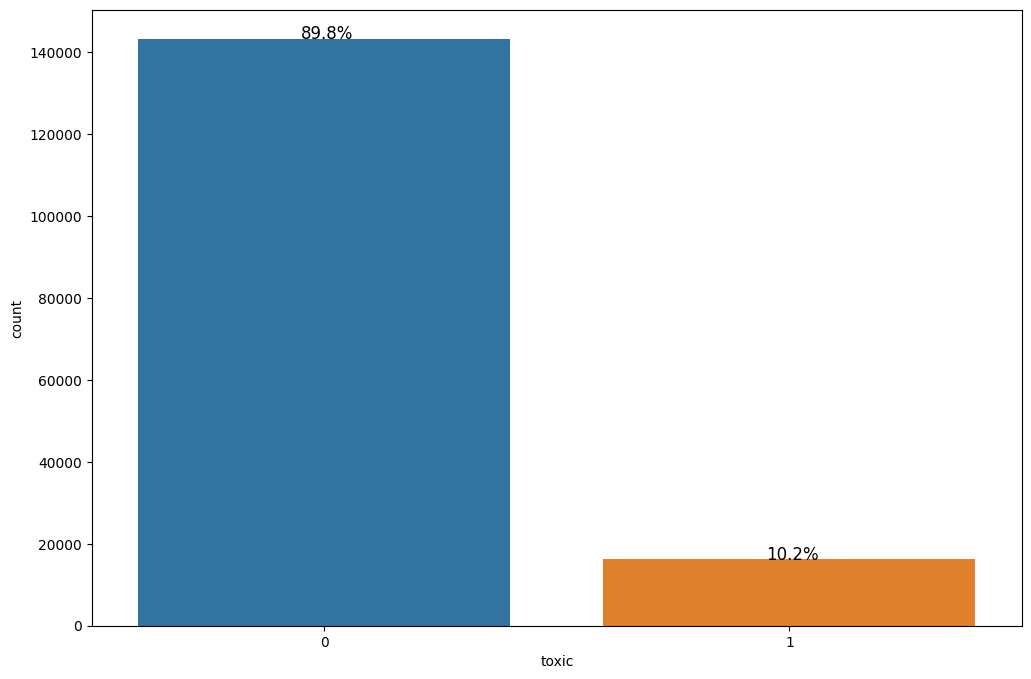

In [3]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
        
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="toxic", data=data)

without_hue(ax, data.toxic)

Как видим у нас дисбаланс классов, очень мало положительных. Отношение отрицательных к положительным 9 к 1

Уменьшим кол-во до 2000 рандомных отзывов, так как наша модель будет очень долго обучатся. А также удалив очень длинные комментарии, из-за которых эмбеддинги не будут работать

In [39]:
sample = data.sample(n=2000, random_state=12345).reset_index(drop=True)

In [44]:
def eda(data):
    data.info()
    display(data.head())
    display(data.tail())

In [45]:
eda(sample)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   toxic   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,text,toxic
0,Expert Categorizers \n\nWhy is there no menti...,0
1,"""\n\n Noise \n\nfart* talk. """,1
2,"An indefinite block is appropriate, even for a...",0
3,I don't understand why we have a screenshot of...,0
4,"Hello! Some of the people, places or things yo...",0


,text,toxic
1995,Tecmobowl is acting like one of the vandals in...,0
1996,"""\nI agree that to warrant an article, a colle...",0
1997,Trying to distinguish the medical nature of th...,0
1998,Who the hell are you to warn me kid! If I did ...,1
1999,""" August 2009 (UTC)\n\n Shannon, you wrote:\n\...",0


Инициализируем наши комментарии

In [46]:
corpus = sample['text']

Инициализируем переменную для токенизации 

In [47]:

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")


Проведем токенизацию

In [48]:

tokenized = corpus.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))




Надем максимальную длинну вектора в датафреме

In [49]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)


max_len

512

Преобразуем данные в формат тензоров 

In [50]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Загрузим преобученную модель для эмбеддинга

In [23]:
model = AutoModel.from_pretrained("unitary/toxic-bert")

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Проведем эмбеддинг с батчами размером 100 объектов. С помощью функции .no_grad избежим градиентного бустинга

In [24]:
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/2 [00:00<?, ?it/s]

Разобьем данные на выборки

In [25]:
features = np.concatenate(embeddings)
target = sample['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)


In [52]:
rs = 270333
cv = StratifiedKFold(n_splits=5)


# Пайплайн для модели Logisticregression
pipline_1 = Pipeline((
    ('Logisticregression', LogisticRegression(random_state = rs)),
))

# Пайплайн для модели RandomForestClassifier
pipline_2 = Pipeline((
    ('RandomForestClassifier', RandomForestClassifier(random_state = rs)),
))



In [34]:
param_1 = {}
param_1['Logisticregression__class_weight'] = ['balanced']
param_1['Logisticregression__solver'] = ['liblinear']


# Парамаетры для RandomForestClassifier
param_2 = {}
param_2['RandomForestClassifier__max_depth'] = [10, 15, 20]
param_2['RandomForestClassifier__n_estimators'] = [10, 50, 100]
param_2['RandomForestClassifier__min_samples_split'] = [2, 10]
param_2['RandomForestClassifier__min_samples_leaf'] = [2, 10]


In [35]:
pars = [param_1, param_2]
pips = [pipline_1, pipline_2]

In [36]:
for i in range(len(pars)):
    gs = GridSearchCV(pips[i], pars[i], cv=cv, scoring='f1')
    gs.fit(features_train, target_train)
    print(f'Лучшие параметры GridSearch модели № {i+1}:')
    display(gs.best_params_)
    print('Лучший f1_score на train:', gs.best_score_.round(4))
    print('')
    print('<======================================================>')
    print('')

Лучшие параметры GridSearch модели № 1:


{'Logisticregression__class_weight': 'balanced',
 'Logisticregression__solver': 'liblinear'}

Лучший f1_score на train: 0.8457

<======================================================>

Лучшие параметры GridSearch модели № 2:


{'RandomForestClassifier__max_depth': 10,
 'RandomForestClassifier__min_samples_leaf': 10,
 'RandomForestClassifier__min_samples_split': 2,
 'RandomForestClassifier__n_estimators': 50}

Лучший f1_score на train: 0.9429

<======================================================>



In [53]:
predict = gs.best_estimator_.predict(features_test)
f1_sc = f1_score(target_test, predict)
display('Показатель f1 на тестово выборке', f1_sc)

'Показатель f1 на тестово выборке'

1.0

## Выводы

Была произведена обработка данных - с помощью BERT. Проведена токенизация, эмбеддинг предобученно моделью AutoModel.  
Была выбрана предварительно обученные веса BERT - "unitary/toxic-bert". Так как при выборе базовых весов, метрика качества получалась очень низкая.
В данных был дисбаланс - больше отрицательных комментариев.
Обучены 2 модели. Модель LogisticRegression показала лучшую метрику f1.